**Основные этапы:**
1. [Загрузка и первичный осмотр данных](#load) — понимаем структуру, типы данных и пропуски.
2. [Обработка пропусков и базовые трансформации](#cleaning) — заполнение NaN, кодирование пола, очистка возраста.
3. [Обработка опыта работы (Experience)](#experience) — разворачивание JSON, расчет длительности работы в месяцах.
5. [Обработка образования (Education)](#education) — кодирование уровней (бакалавр/магистр), парсинг вузов и сопоставление с рейтингами.
6. [Извлечение и очистка навыков (Skills Extraction)](#skills) — NLP-пайплайн для очистки списка скиллов и отбора значимых признаков.
7. [Структура Финального Датасета](#data_structure_final)

In [ ]:
import pandas as pd
import re
import json
import numpy as np
from difflib import SequenceMatcher
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
# !pip install langdetect googletrans==4.0.0-rc1 
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from googletrans import Translator
from tqdm.auto import tqdm
# import sys
# !{sys.executable} -m pip install nltk gensim tqdm
# !pip install nltk gensim tqdm
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
# import sys
# !{sys.executable} -m pip install tabulate

import seaborn as sns
from datetime import datetime

In [259]:
import sys
!{sys.executable} -m pip install node2vec

  Using cached node2vec-0.5.0-py3-none-any.whl (7.2 kB)



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [127]:


df = pd.read_csv("resumes_details.csv")


<a id="load"></a>
## 1. Первичный анализ данных

**Изначальные поля датасета:**

#### 1. Идентификаторы и Метаданные
* **`resume_id`** *(object)*: Уникальный идентификатор резюме в системе (хэш). Используется для удаления дубликатов.
* **`url`** *(object)*: Прямая ссылка на резюме на сайте hh.ru. Полезна для проверки данных вручную.
* **`parsed_at`** *(object)*: Дата и время, когда резюме было скачано. Техническое поле.

#### 2. Основная информация о кандидате
* **`title`** *(object)*: Желаемая должность (заголовок резюме). Например: *"Системный администратор"*, *"Python developer"*. Это ключевой признак для определения профиля кандидата.
* **`location`** *(object)*: Город проживания кандидата. Например: *"Москва"*, *"Санкт-Петербург"*. Требует унификации.
* **`age`** *(object)*: Возраст кандидата в сыром виде. Содержит мусор (текст *"год"*, *"лет"*, *"years"*). **Требует очистки** и приведения к числу (`int`).
* **`gender`** *(object)*: Пол кандидата. Содержит разные варианты написания (*"Мужчина"*, *"Male"*, *"Женщина"*). **Требует маппинга** в бинарный формат (0/1).
* **`salary`** *(object)*: Желаемая зарплата. Очень "грязное" поле: разные валюты (RUB, USD, EUR), текст (*"на руки"*), диапазоны. **Требует приведения к единой валюте**.
* **`about`** *(object)*: Текстовое поле "О себе". Свободное описание, часто содержит софт-скиллы или мотивацию.

#### 3. Навыки (Skills)
* **`skills`** *(object)*: Список ключевых навыков в виде одной строки, разделенной символами. Пример: *"Python, SQL, Git"*.
* **`skills_count`** *(int64)*: Числовое поле — количество указанных навыков (уже подсчитано парсером).

#### 4. Опыт работы (Experience)
* **`experience_json`** *(object)*: Самое информативное поле. Содержит список словарей (JSON) со всей историей работы: названия компаний, должности, периоды работы и описание обязанностей. **Требует "разворачивания"** для анализа.
* **`experience_count`** *(int64)*: Общее количество мест работы, указанных в резюме.

#### 5. Образование (Education)
* **`education_level`** *(object)*: Уровень образования. Категориальный признак. Примеры: *"Высшее"*, *"Среднее специальное"*, *"Магистр"*. Требует кодирования.
* **`education_json`** *(object)*: Детальная информация об основном образовании в формате JSON (ВУЗ, факультет, год выпуска).
* **`education_count`** *(int64)*: Количество записей об основном образовании (например, бакалавриат + магистратура = 2).
* **`additional_education_json`** *(object)*: Информация о курсах повышения квалификации, сертификатах и тренингах (JSON).
* **`additional_education_count`** *(int64)*: Количество пройденных курсов/сертификатов.

In [128]:

df.info()

print("=== Размер датафрейма ===")
print(f"Строк: {df.shape[0]}, Столбцов: {df.shape[1]}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26053 entries, 0 to 26052
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   resume_id                   26053 non-null  object
 1   url                         26053 non-null  object
 2   title                       26053 non-null  object
 3   location                    26052 non-null  object
 4   age                         24419 non-null  object
 5   gender                      26053 non-null  object
 6   salary                      14288 non-null  object
 7   skills                      26052 non-null  object
 8   skills_count                26053 non-null  int64 
 9   about                       22992 non-null  object
 10  experience_json             26053 non-null  object
 11  experience_count            26053 non-null  int64 
 12  education_json              26053 non-null  object
 13  education_count             26053 non-null  in

In [129]:
df.isnull().sum()

resume_id                         0
url                               0
title                             0
location                          1
age                            1634
gender                            0
salary                        11765
skills                            1
skills_count                      0
about                          3061
experience_json                   0
experience_count                  0
education_json                    0
education_count                   0
education_level                   0
additional_education_json         0
additional_education_count        0
parsed_at                         0
dtype: int64

<a id="cleaning"></a>
## 2. Обработка пропусков и базовые трансформации

**Стратегия заполнения пропусков:**
1.  **Категориальные признаки (`gender`):** Заполняем модой (самым частым значением), так как пропусков мало, и это наиболее вероятное значение.
2.  **Числовые признаки (`experience_count`, `education_count`):** Пропуски заполняем нулями (логика: если данных нет, значит, опыта/образования нет или не указано).
3.  **Удаление:** Убираем технические колонки (`resume_id`, `parsed_at`), не несущие пользы для моделирования. `url` на данном этапе оставляем, так как он понадобится для отслеживания правильности обработки столбцов вручную

In [130]:
# ['location', 'age', 'gender']

for col in [ 'gender']:
    most_common = df[col].mode().iloc[0]  # находит самое частое значение
    df[col] = df[col].fillna(most_common)

for col in ['experience_count', 'education_count', 'additional_education_count']:
    df[col] = df[col].fillna(0)

In [131]:
df = df.drop(columns=['resume_id', 'parsed_at']) # , 'url'

# Описательная статистика

**Что получаем:**  
- Для числовых колонок: count, mean, std, min, max и пр.  
- Для объектных (текстовых) колонок: top, freq и число уникальных значений.
Статистика

In [132]:
df.describe(include=[float, int])

,skills_count,experience_count,education_count,additional_education_count
count,26053.00000,26053.000000,26053.000000,26053.000000
mean,18.37869,6.329175,2.521168,1.807815
std,9.58100,3.371748,0.909576,3.135391
min,0.00000,0.000000,1.000000,0.000000
25%,11.00000,4.000000,2.000000,0.000000
50%,18.00000,6.000000,2.000000,0.000000
75%,27.00000,8.000000,3.000000,3.000000
max,38.00000,41.000000,23.000000,62.000000


In [133]:
df.describe(include=[object])

,url,title,location,age,gender,salary,skills,about,experience_json,education_json,education_level,additional_education_json
count,26053,26053,26052,24419,26053,14288,26052,22992,26053,26053,26053,26053
unique,26053,13557,1119,119,8,761,24731,22766,25435,25235,24,11208
top,https://hh.ru/resume/2c7342a80008a535640039ed1f466456413152?query=%D0%92%D0%B5%D0%B1+%D0%B4%D0%B8%D0%B7%D0%B0%D0%B9%D0%BD%D0%B5%D1%80&searchRid=17622856268450a7a5ac5598d2719027&hhtmFrom=resume_search_result,Системный администратор,Москва,31 год,Мужчина,100 000 ₽ на руки,"Русский — Родной, Английский — A1 — Начальный",В последние годы проходил обучение без возможности работать.,[],"[{""name"": null, ""organization"": null, ""period"": null, ""level"": null, ""result"": null}]",Высшее образование,[]
freq,1,1100,5881,1130,17621,1104,196,51,602,662,13296,14788


В столбцах age и gender уникальных значений больше чем должно было быть

### Нормализация возраста и пола

* **Пол (`gender`):** Переводим текстовые значения (Мужчина/Женщина/Male/Female) в бинарный формат (1 - Мужчина, 0 - Женщина).
* **Возраст (`age`):** Извлекаем числовое значение из строк вида "31 год", "25 years"

In [134]:
for col in ['age', 'gender']:
    if col not in df.columns:
        print(f"Столбец '{col}' не найден в датафрейме.\n")
        continue

    print(f"\n=== {col} ===")
    print(f"Всего непустых значений: {df[col].notna().sum()}")
    print(f"Количество уникальных (не NaN): {df[col].nunique(dropna=True)}\n")

    # Выводим значение и количество
    for val, count in df[col].value_counts(dropna=False).items():
        print(f"{repr(val)} — {count}")

    print("\n" + "-"*100 + "\n")


=== age ===
Всего непустых значений: 24419
Количество уникальных (не NaN): 119

nan — 1634
'31 год' — 1130
'33 года' — 1087
'34 года' — 1067
'30 лет' — 1053
'32 года' — 1049
'28 лет' — 1033
'29 лет' — 1022
'37 лет' — 1013
'35 лет' — 1012
'36 лет' — 1010
'27 лет' — 979
'26 лет' — 882
'38 лет' — 865
'39 лет' — 842
'25 лет' — 753
'40 лет' — 698
'41 год' — 658
'42 года' — 616
'24 года' — 524
'43 года' — 516
'44 года' — 426
'45 лет' — 404
'46 лет' — 338
'23 года' — 330
'47 лет' — 292
'48 лет' — 283
'49 лет' — 260
'50 лет' — 220
'51 год' — 216
'52 года' — 165
'22 года' — 160
'53 года' — 157
'36 years' — 133
'38 years' — 131
'55 лет' — 124
'54 года' — 122
'37 years' — 121
'34 years' — 116
'35 years' — 113
'56 лет' — 105
'40 years' — 104
'41 year' — 104
'29 years' — 97
'39 years' — 95
'32 years' — 93
'33 years' — 93
'31 year' — 85
'58 лет' — 79
'57 лет' — 78
'42 years' — 76
'46 years' — 74
'43 years' — 73
'28 years' — 73
'30 years' — 73
'44 years' — 69
'27 years' — 68
'45 years' — 68
'59 лет'

In [135]:
gender_map = {
    'Мужчина': 1,
    'Male': 1,
    'Ер': 1,
    'Kishi': 1,
    'Женщина': 0,
    'Female': 0,
    'Әйел': 0
}

df['gender'] = df['gender'].map(gender_map)


In [136]:
def extract_age(age_str):
    if pd.isna(age_str):
        return None
    match = re.search(r'\d+', str(age_str))
    return int(match.group()) if match else None

df['age'] = df['age'].apply(extract_age)

### 3. Парсинг зарплат (`salary`)

Поле `salary` содержит разнородные данные: "100 000 руб", "2000 USD", "от 500 EUR".

**Логика обработки:**
1.  Определяем валюту и конвертируем в Рубли по фиксированному курсу.
2.  Обрабатываем множители (например, "5k" -> 5000).
3.  Если указан диапазон ("100-150к"), берем среднее арифметическое.

In [137]:
# Примерные курсы валют к рублю
currency_to_rub = {'USD': 100, 'EUR': 110, 'RUB': 1}

def parse_salary(s):
    if pd.isna(s):
        return None
    s = str(s).lower().replace(' ', '')
    
    # Определяем валюту
    if 'usd' in s or '$' in s:
        currency = 'USD'
    elif 'eur' in s or '€' in s:
        currency = 'EUR'
    elif 'руб' in s or 'р' in s or '₽' in s:
        currency = 'RUB'
    else:
        currency = 'RUB'  # по умолчанию рубли

    # Определяем множитель (k, тыс.)
    multiplier = 1
    if 'k' in s or 'тыс' in s:
        multiplier = 1000

    numbers = re.findall(r'\d+', s)
    if not numbers:
        return None
    numbers = [int(n) for n in numbers]

    # Если диапазон, берём среднее
    salary = sum(numbers) / len(numbers)

    # Переводим в рубли
    salary_rub = salary * multiplier * currency_to_rub[currency]
    return salary_rub

df['salary'] = df['salary'].apply(parse_salary)



После выполнения очистки и приведения ключевых признаков (`age`, `salary`, `gender`) к числовому формату, мы проводим повторный анализ статистики.

Также проводим **расчет квантилей (5% и 95%):** Этот шаг позволяет быстро определить **реалистичный рабочий диапазон** распределения данных и установить, сколько записей из JSON-полей (`experience_json`, `education_json`) имеет смысл включать в анализ.

In [138]:
df.describe(include=[float, int])

,age,gender,salary,skills_count,experience_count,education_count,additional_education_count
count,24419.000000,26052.000000,14288.000000,26053.00000,26053.000000,26053.000000,26053.000000
mean,35.937385,0.757984,1635.974629,18.37869,6.329175,2.521168,1.807815
std,8.626697,0.428312,7980.961737,9.58100,3.371748,0.909576,3.135391
min,14.000000,0.000000,0.333333,0.00000,0.000000,1.000000,0.000000
25%,29.000000,1.000000,40.000000,11.00000,4.000000,2.000000,0.000000
50%,35.000000,1.000000,75.000000,18.00000,6.000000,2.000000,0.000000
75%,41.000000,1.000000,150.000000,27.00000,8.000000,3.000000,3.000000
max,122.000000,1.000000,104500.000000,38.00000,41.000000,23.000000,62.000000


In [139]:
df.describe(include=[object])

,url,title,location,skills,about,experience_json,education_json,education_level,additional_education_json
count,26053,26053,26052,26052,22992,26053,26053,26053,26053
unique,26053,13557,1119,24731,22766,25435,25235,24,11208
top,https://hh.ru/resume/2c7342a80008a535640039ed1f466456413152?query=%D0%92%D0%B5%D0%B1+%D0%B4%D0%B8%D0%B7%D0%B0%D0%B9%D0%BD%D0%B5%D1%80&searchRid=17622856268450a7a5ac5598d2719027&hhtmFrom=resume_search_result,Системный администратор,Москва,"Русский — Родной, Английский — A1 — Начальный",В последние годы проходил обучение без возможности работать.,[],"[{""name"": null, ""organization"": null, ""period"": null, ""level"": null, ""result"": null}]",Высшее образование,[]
freq,1,1100,5881,196,51,602,662,13296,14788


In [140]:
cols = [
    "skills_count",
    "experience_count",
    "education_count",
    "additional_education_count"
]

quantiles = [0.05, 0.10, 0.15, 0.25, 0.5, 0.75, 0.80, 0.85, 0.90, 0.95]

# вывод расширенной статистики по квантилям
desc = df[cols].describe(percentiles=quantiles)
print(desc)

       skills_count  experience_count  education_count  \
count   26053.00000      26053.000000     26053.000000   
mean       18.37869          6.329175         2.521168   
std         9.58100          3.371748         0.909576   
min         0.00000          0.000000         1.000000   
5%          3.00000          2.000000         2.000000   
10%         5.00000          2.000000         2.000000   
15%         7.00000          3.000000         2.000000   
25%        11.00000          4.000000         2.000000   
50%        18.00000          6.000000         2.000000   
75%        27.00000          8.000000         3.000000   
80%        29.00000          9.000000         3.000000   
85%        31.00000         10.000000         3.000000   
90%        32.00000         11.000000         4.000000   
95%        32.00000         12.000000         4.000000   
max        38.00000         41.000000        23.000000   

       additional_education_count  
count                26053.000000  

### 4. Обработка и унификация локаций (Location) 

Для устранения дубликатов, вызванных разными языками (`Moscow` vs. `Москва`), мы использовали контекстный подход. Сначала был определен язык каждого резюме по содержимому поля `about`. Если язык не русский, название города автоматически переводилось на русский язык с помощью библиотеки `googletrans`, что обеспечило масштабную унификацию локаций.

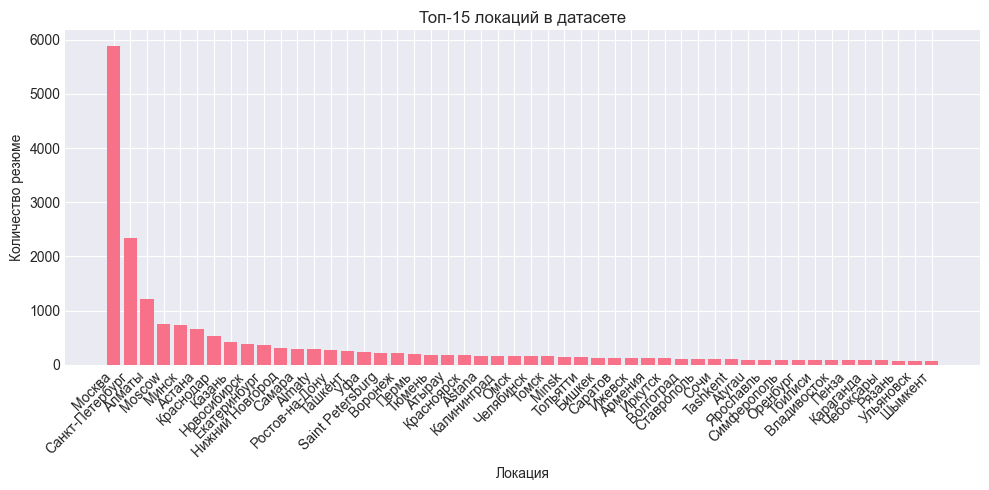

In [141]:

# Считаем частоты
loc_counts = df['location'].value_counts()

# Берём топ-15
top_locs = loc_counts.head(50)

plt.figure(figsize=(10, 5))
plt.bar(top_locs.index, top_locs.values)
plt.title("Топ-15 локаций в датасете")
plt.xlabel("Локация")
plt.ylabel("Количество резюме")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [142]:
df['location'].isnull().sum()


np.int64(1)

In [143]:
tqdm.pandas()
translator = Translator()
CONTEXT_COLUMN = 'about'

In [ ]:
# Кэш для ускорения:
LANGUAGE_CACHE = {}

def get_language(text):
    """Определяет язык текста, используя кэш."""
    if pd.isna(text) or not isinstance(text, str) or len(text) < 20:
        return 'ru' # Слишком короткий текст считаем русским по умолчанию
    
    key = text[:50] # Ключ по первым 50 символам
    if key in LANGUAGE_CACHE:
        return LANGUAGE_CACHE[key]
    
    try:
        lang = detect(text)
        LANGUAGE_CACHE[key] = lang
        return lang
    except LangDetectException:
        # Если не удалось определить язык (много цифр, мусор)
        LANGUAGE_CACHE[key] = 'unknown'
        return 'unknown'
print("Определение языка резюме...")
df['resume_language'] = df[CONTEXT_COLUMN].progress_apply(get_language)

Определение языка резюме...


100%|██████████| 26053/26053 [01:12<00:00, 359.64it/s]


In [145]:

language_counts = df['resume_language'].value_counts()

print("Распределение резюме по языкам:")
print(language_counts)


Распределение резюме по языкам:
resume_language
ru         22559
en          2984
bg           168
et            99
unknown       89
mk            33
uk            12
ro            11
nl             9
de             9
fr             8
da             8
af             8
ca             7
no             6
sv             6
tr             5
it             5
tl             5
sl             4
id             3
vi             2
cy             2
hr             2
pt             2
es             2
fi             1
sq             1
sk             1
sw             1
pl             1
Name: count, dtype: int64


In [146]:

TRANSLATION_CACHE = {}

def translate_location_if_needed(row):
    """Переводит локацию на русский, если язык резюме не 'ru'."""
    location = row['location']
    lang = row['resume_language']
    
    if pd.isna(location) or lang == 'ru' or lang == 'unknown':
        return location
        
    key = (location.strip().lower(), lang)
    if key in TRANSLATION_CACHE:
        return TRANSLATION_CACHE[key]

    try:
        # Пытаемся перевести на русский (dest='ru')
        translated = translator.translate(location, dest='ru').text
        
        # Проверяем, что перевод не является техническим мусором или ошибкой
        if translated and translated.strip().lower() != location.strip().lower():
             TRANSLATION_CACHE[key] = translated.strip()
             return translated.strip()
        
        # Если перевод не изменил строку (скорее всего, она уже русская/ошибка), возвращаем оригинал
        TRANSLATION_CACHE[key] = location.strip()
        return location.strip()
        
    except Exception:
        # В случае ошибки перевода
        TRANSLATION_CACHE[key] = location.strip()
        return location.strip()
print("Перевод нерусских локаций...")
df['location_new'] = df.progress_apply(translate_location_if_needed, axis=1)

df['location'] = df['location_new']
df.drop(columns=['location_new'], inplace=True)

Перевод нерусских локаций...


100%|██████████| 26053/26053 [03:53<00:00, 111.72it/s]


### 4 Визуальный осмотр сырых категориальных признаков

Мы полное содержимое ключевых текстовых и JSON-колонок (`skills`, `about`, `*\_json`) для одного  резюме перед тем, как приступать к их многоступенчатому очистке.

In [ ]:
# отключаем сокращённый вывод
pd.set_option('display.max_colwidth', None)
cols = [
    "title",
    "skills",
    "about",
    "experience_json",
    "education_json",
    "additional_education_json"
]

# вывод полной строки по этим колонкам
print(df.loc[15, cols])

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

<a id="experience"></a>
## 4. Обработка опыта работы (`experience_json`)

Данные об опыте хранятся в JSON-формате (список мест работы). Мы разворачиваем этот список в  структуру таблицы.

1.   Извлекаем поля `position`, `company`, `period`, `description` для каждого места работы.
2.   Берем до 4 последних мест работы (создаем колонки `job_1_...` до `job_5_...`).
3.  * Парсим строки вида "3 года 2 месяца" -> переводим в месяцы (`duration_months`).
    * Определяем флаг `is_current` (текущее место работы), если в дате есть "по настоящее время".
    * Добавляем флаг `is_top_it_company_flag`, указывающий, работал ли кандидат хотя бы на одном из мест работы в компании из заранее определенного списка топ-IT компаний.

In [ ]:
MAX_JOBS = 4

def expand_experience(row):
    try:
        experiences = json.loads(row['experience_json'])
        if not isinstance(experiences, list):
            experiences = []
    except (json.JSONDecodeError, TypeError):
        experiences = []

    # --- Удаляем полные дубликаты внутри списка ---
    unique_jobs = []
    seen = set()
    for job in experiences:
        # формируем ключ для проверки дублей
        key = (
            job.get('position', '').strip() if job.get('position') else '',
            job.get('company', '').strip() if job.get('company') else '',
            job.get('period', '').strip() if job.get('period') else '',
            job.get('description', '').strip() if job.get('description') else ''
        )
        if key not in seen:
            seen.add(key)
            unique_jobs.append(job)

    unique_jobs = unique_jobs[-MAX_JOBS:]

    expanded = {}
    for i in range(MAX_JOBS):
        if i < len(unique_jobs):
            job = unique_jobs[i]
            expanded[f'job_{i+1}_position'] = job.get('position', np.nan)
            expanded[f'job_{i+1}_company'] = job.get('company', np.nan)
            expanded[f'job_{i+1}_period'] = job.get('period', np.nan)
            expanded[f'job_{i+1}_description'] = job.get('description', np.nan)
        else:
            expanded[f'job_{i+1}_position'] = np.nan
            expanded[f'job_{i+1}_company'] = np.nan
            expanded[f'job_{i+1}_period'] = np.nan
            expanded[f'job_{i+1}_description'] = np.nan

    return pd.Series(expanded)

expanded_jobs_df = df.apply(expand_experience, axis=1)

df = pd.concat([df, expanded_jobs_df], axis=1)


In [ ]:
duplicate_rows = []
for idx, row in df.iterrows():
    jobs = []
    for i in range(1, MAX_JOBS + 1):
        pos = row.get(f'job_{i}_position')
        comp = row.get(f'job_{i}_company')
        per = row.get(f'job_{i}_period')
        desc = row.get(f'job_{i}_description')

        # Если все поля NaN, прекращаем проверку
        if pd.isna(pos) and pd.isna(comp) and pd.isna(per) and pd.isna(desc):
            continue

        job_tuple = (pos, comp, per, desc)
        # Проверяем, есть ли такой же кортеж в списке jobs
        if job_tuple in jobs:
            duplicate_rows.append(idx)
            break 
        jobs.append(job_tuple)

# Где нашли дубли
duplicate_rows = list(set(duplicate_rows))
print(f"Найдено {len(duplicate_rows)} резюме с дублирующимися позициями в первых {MAX_JOBS} слотах.")

position_cols = [f'job_{i}_position' for i in range(1, MAX_JOBS + 1)]
company_cols = [f'job_{i}_company' for i in range(1, MAX_JOBS + 1)]
df_duplicates = df.loc[duplicate_rows, position_cols + company_cols]

Найдено 0 резюме с дублирующимися позициями в первых 4 слотах.


Здесь и далее будет частый вывод статистики пропусков (`df.isnull().sum()`) после сложных операций для контроля их правильности.

In [150]:
for col, miss in df.isnull().sum().items():
    print(f"{col}: {miss}")


url: 0
title: 0
location: 1
age: 1634
gender: 1
salary: 11765
skills: 1
skills_count: 0
about: 3061
experience_json: 0
experience_count: 0
education_json: 0
education_count: 0
education_level: 0
additional_education_json: 0
additional_education_count: 0
resume_language: 0
job_1_position: 602
job_1_company: 602
job_1_period: 602
job_1_description: 602
job_2_position: 2635
job_2_company: 2635
job_2_period: 2635
job_2_description: 2635
job_3_position: 5083
job_3_company: 5083
job_3_period: 5083
job_3_description: 5083
job_4_position: 8329
job_4_company: 8329
job_4_period: 8329
job_4_description: 8329


In [151]:

def parse_period(period_str):
    """
    Универсальный парсер периода для рус/англ/казах.
    Возвращает:
        - duration в месяцах
        - флаг текущей работы (1/0)
    """
    if not isinstance(period_str, str):
        return np.nan, np.nan

    s = period_str.lower()

    # Флаг текущей работы
    is_current = 1 if any(x in s for x in ["по настоящее время", "currently", "present", "қазіргі уақытқа дейін"]) else 0

    # Ищем годы
    years_match = re.search(r'(\d+)\s*(?:год|года|лет|year|years|жыл)', s, flags=re.IGNORECASE)
    years = int(years_match.group(1)) if years_match else 0

    # Ищем месяцы
    months_match = re.search(r'(\d+)\s*(?:месяц|месяца|месяцев|month|months|ай|oylar)', s, flags=re.IGNORECASE)
    months = int(months_match.group(1)) if months_match else 0

    # duration в месяцах
    duration_months = years*12 + months if (years_match or months_match) else np.nan

    return duration_months, is_current

period_cols = [f'job_{i}_period' for i in range(1, MAX_JOBS + 1)]

for col in period_cols:
    duration_col = col.replace('_period', '_duration_months')
    is_current_col = col.replace('_period', '_is_current')
    df[[duration_col, is_current_col]] = df[col].apply(lambda x: pd.Series(parse_period(x)))


In [152]:
for col, miss in df.isnull().sum().items():
    print(f"{col}: {miss}")


url: 0
title: 0
location: 1
age: 1634
gender: 1
salary: 11765
skills: 1
skills_count: 0
about: 3061
experience_json: 0
experience_count: 0
education_json: 0
education_count: 0
education_level: 0
additional_education_json: 0
additional_education_count: 0
resume_language: 0
job_1_position: 602
job_1_company: 602
job_1_period: 602
job_1_description: 602
job_2_position: 2635
job_2_company: 2635
job_2_period: 2635
job_2_description: 2635
job_3_position: 5083
job_3_company: 5083
job_3_period: 5083
job_3_description: 5083
job_4_position: 8329
job_4_company: 8329
job_4_period: 8329
job_4_description: 8329
job_1_duration_months: 603
job_1_is_current: 602
job_2_duration_months: 2636
job_2_is_current: 2635
job_3_duration_months: 5084
job_3_is_current: 5083
job_4_duration_months: 8330
job_4_is_current: 8329


Ищем записи, которые не удалось распарсить

In [153]:

total_unparsed_mask = pd.Series(False, index=df.index)

for i in range(1, MAX_JOBS + 1):
    period_col = f'job_{i}_period'
    duration_col = f'job_{i}_duration_months'
    
    mask = df[period_col].notna() & df[duration_col].isna()
    total_unparsed_mask = total_unparsed_mask | mask

total_unparsed_count = total_unparsed_mask.sum()
print(f"Общее количество строк (резюме) с нераспарсенным периодом в первых {MAX_JOBS} позициях: {total_unparsed_count}")

# 3. Удаляем строки, для которых парсинг не удался
df_before_drop = len(df)
df = df[~total_unparsed_mask].copy()

print(f"Удалено строк: {df_before_drop - len(df)}")
print(f"Осталось строк в датасете: {len(df)}")

Общее количество строк (резюме) с нераспарсенным периодом в первых 4 позициях: 1
Удалено строк: 1
Осталось строк в датасете: 26052


In [ ]:
import pandas as pd
import re
from typing import Set, Any

MAX_JOBS = 4 
def normalize_company_name(name: str) -> str:
    """
    Приводит название компании к нижнему регистру, удаляет знаки препинания, 
    формы собственности (ООО, ПАО, LLC и т.д.) и лишние пробелы.
    """
    if not isinstance(name, str) or not name.strip():
        return ""
    
    name = name.lower()
    name = re.sub(r'[^\w\s]', '', name)
    
    # Удаление распространенных форм собственности
    stop_words = [
        r'\s*ооо\s*', r'\s*ао\s*', r'\s*пао\s*', r'\s*оао\s*', r'\s*зао\s*', 
        r'\s*ип\s*', r'\s*гк\s*', r'\s*нп\s*', r'\s*ано\s*', r'\s*фгуп\s*',
        r'\s*llc\s*', r'\s*inc\s*', r'\s*corp\s*', r'\s*ltd\s*', r'\s*sa\s*',
        r'\s*ao\s*', r'\s*zao\s*', r'\s*open joint stock company\s*'
    ]
    for sw in stop_words:
        name = re.sub(sw, ' ', name)
        
    name = re.sub(r'\s+', ' ', name).strip()
    return name
TOP_IT_COMPANIES_NORMALIZED: Set[str] = {
    "яндекс", "yandex", "яндекс проект", "яндекс маркет",
    "вк", "vk", "mailru", "mail ru", "mail.ru", "вконтакте",
    "сбер", "sber", "сбербанк", "sberbank", "сбертех", "sbertech",
    "тинькофф", "tinkoff", "тинькофф банк", "tinkoff bank",
    "авито", "avito",
    "озон", "ozon",
    "wildberries", "вайлдберриз", "вайлдберриз",
    "mvideo", "мвидео",
    "ozon logistics", "ozonlogistics",
    "2гис", "2gis",
    "лаборатория касперского", "kaspersky", "kaspersky lab", "касперский",
    "positive technologies", "позитив технологис", "позитив",
    "drweb", "доктор веб", "doctor web",
    "cybertrust", "кибертраст",
    "jetbrains", "джетбрейнс",
    "1c", "1с",
    "ланит", "lanit",
    "крок", "croc",
    "наумен", "naumen",
    "т1", "t1 holding", "t1", "ти1",
    "инфосистемы джет", "infosystems jet", "infosystemsjet",
    "ибс", "ibs",
    "ядро", "yadro",
    "selectel", "селектел", "selectel cloud",
    "softline", "софтлайн",
    "ocs distribution", "ocs", "ocs distribution russia",
    "nix", "nix solutions", "nixsolutions",
    "itbox", "айтибокс",
    "mail group", 
    "headhunter", "хедхантер", "hh", "hh.ru",
    "циан", "cian", "domclick", "домклик", "дом клик",
    "wildberries","вб", "яндекс маркет", "ozon", "avito", "lamoda", "ламода",
    "beru", "беру",
    "ростелеком", "rostelecom",
    "мтс web services", "мтс", "mts", "mts web",
    "мегафон", "megafon",
    "tele2", "теле2",
    "альфа банк", "alfabank", "альфа", "alfagroup",
    "точка", "tochka",
    "росбанк", "rosbank",
    "втб", "vtb", "vtb digital",
    "касса",
    "тинькофф", "tinkoff",
    "qiwi", "киви",
    "yoomoney", "юманей", "юмани", "yandex money",
    "epam", "epam systems", "эпам",
    "andersen", "andersen labs", "andersen lab", "андерсен",
    "ciklum", "циклюм",
    "itechart", "айтчарт",
    "oleg",  
    "скб контур", "skb kontur", "контур",
    "artvell", "артвелл", "artwell", "artvell", "артвелл", "artvell technologies",
    "galaktika", "галактика",
    "redsoft", "ред софт", "red soft",
    "ametist", "аметист",
    "agrtech", 
    "икс холдинг", "xholding", "x holding", "иксхолдинг",
    "группа plus", "группа плюс", "плюс", "plus group",
    "astel", "астел", "astra group", "гк астра",
    "kaspi", "каспи", "kaspi bank", "kaspi.kz",
    "halyk bank", "халык банк", "halyk",
    "kolesakz", "колесакз", "kolesa", "kolesa group",
    "kolesa.kz", 
    "epm", 
    "epam", "epam systems",
    "wargaming", "варгейминг",
    "viber", "вайбер",
    "globant", 
    "hitech интеграция", "хайтек интеграция", "hitech integration",
    "unitech", "унитех",
    "3logic", "3logic group",
    "k2tech", "к2тех",
    "gmcs", "гмкс", "gmcs group",
    "c-terra", "с-терра", "с терра",
    "ispring", "айспринг",
    "agima", "агима",
    "directum", "директум",
    "s-terra csp", "с терра сип",
    "safetyinfo", "защитainfo",
    "ibm russia", "ibm", "ibm russia",
    "oracle russia", "oracle",
    "microsoft russia", "microsoft",
    "sap", "sap russia",
    "softline distribution", "softline",
    "merlion", "мерлион",
    "dcinternational", "dc international",
    "ingram micro", "ingrammicro",
    "itmo", "итмо",  
    "it group", "itg",  
    "itfb group", "itfb",
    "it-solutions", "it solutions",
    "infowatch", "инфовотч",
    "croc", "крок",
    "lanit", "ланит",
    "yadro", "ядро",
    "systematika", "систематика",
    "ocs", "ocs distribution",
    "centrist", "центрист",  
    "edison", "эдисон", 
    "sbercloud", "сберклауд", "sber cloud",
    "mts cloud", "mts cloud services",
    "mail cloud", "mail cloud services",
    "my.games", "mygames", "майгеймс",
    "my dot games", "my.games studios",
    "gameland", "геймленд",
    "gameloft", "гамелофт", 
    "yadro analytics", "yadro analytics",
    "cian analytics", "cian analytics",
    "skoltech", "сколтех",
    "msu", "мгу", 
    "itg", "itg group",
    "itautotech", "итаутотек",
    "it bastion", "айт и бастион", "айтбастион",
    "prooftech it", "pruftek", "пруфтек",
    "redlab", "редлаб",
    "cloud networks", "cloudnetworks", "cloud networks russia",
    "south software company", "южная софтверная компания",
    "gmcs group", "gmcs",
    "cybersec", "киберсек",
    "epam", "epam systems", "epm", "ипам", 
    "kaspersky", "касперский", "kasperskiy",
    "hh", "headhunter", "хх", "хедхантер",
}


def check_top_company_flag(row: pd.Series, max_jobs: int, top_set: Set[str]) -> int:
    """
    Проверяет все поля job_i_company в строке DF на наличие топовой компании.
    Возвращает 1, если найдено совпадение, иначе 0.
    """
    for i in range(1, max_jobs + 1):
        company_key = f'job_{i}_company'
        raw_company_name: Any = row.get(company_key)
        
        if not isinstance(raw_company_name, str) or pd.isna(raw_company_name):
            continue
        
        # Нормализация
        normalized_name: str = normalize_company_name(raw_company_name)
        
        # Точное сопоставление
        if normalized_name in top_set:
            return 1
            
    return 0


df['is_top_it_company_flag'] = df.apply(
    check_top_company_flag, 
    axis=1, 
    max_jobs=MAX_JOBS, 
    top_set=TOP_IT_COMPANIES_NORMALIZED
)

In [201]:

company_cols = [f'job_{i}_company' for i in range(1, MAX_JOBS + 1)]

print("## 10 Примеров, где is_top_it_company_flag = 1")
df_flag_1 = df[df['is_top_it_company_flag'] == 1].head(10)
if not df_flag_1.empty:
    print(df_flag_1[company_cols + ['is_top_it_company_flag']])
else:
    print("Не найдено записей с флагом 1 в первых 10 строках.")

print("\n" + "="*80 + "\n")

print("## 10 Примеров, где is_top_it_company_flag = 0")
df_flag_0 = df[df['is_top_it_company_flag'] == 0].head(10)
if not df_flag_0.empty:
    print(df_flag_0[company_cols + ['is_top_it_company_flag']])
else:
    print("Не найдено записей с флагом 0 в первых 10 строках.")

## 10 Примеров, где is_top_it_company_flag = 1
        job_1_company  \
12           Сбербанк   
17           SberTech   
19     Е-Лайт-Телеком   
32               Сбер   
34             Яндекс   
37               Сбер   
50   Urban University   
62           РТИ, ОАО   
74               Сбер   
103            Яндекс   

                                                                                            job_2_company  \
12                                                                                                    NaN   
17                                                                                             Cleverbots   
19                                                                                       ГК Орион-Телеком   
32                                                                                                 ОКЕНИТ   
34                                                                                                А1, ООО   
37                     

In [ ]:

df.to_csv('dataset_with_periods.csv', index=False, encoding='utf-8')


<a id="education"></a>
## 5. Обработка образования и Рейтинги

### 5.1 Кодирование уровня образования
Приводим текстовые описания (`education_level`) к порядковой шкале:

* 1	Среднее образование

* 2	Среднее специальное образование

* 3	Неоконченное высшее образование

* 4	Бакалавр

* 5	Магистр

* 6	Кандидат наук / PhD / Доктор наук

* 0	Прочие


In [155]:
for col in ['education_level']:
    if col not in df.columns:
        print(f"Столбец '{col}' не найден в датафрейме.\n")
        continue

    print(f"\n=== {col} ===")
    print(f"Всего непустых значений: {df[col].notna().sum()}")
    print(f"Количество уникальных (не NaN): {df[col].nunique(dropna=True)}\n")

    # Выводим значение и количество
    for val, count in df[col].value_counts(dropna=False).items():
        print(f"{repr(val)} — {count}")

    print("\n" + "-"*100 + "\n")


=== education_level ===
Всего непустых значений: 26052
Количество уникальных (не NaN): 23

'Высшее образование' — 13296
'Высшее образование (Бакалавр)' — 2694
'Среднее специальное образование' — 2274
'Высшее образование (Магистр)' — 2165
'Неоконченное высшее образование' — 1953
'Higher education' — 1506
'Образование' — 636
'Higher education (master)' — 450
'Higher education (bachelor)' — 404
'Высшее образование (Кандидат наук)' — 212
'Среднее образование' — 163
'Incomplete higher education' — 90
'Secondary special education' — 73
'Higher education (PhD)' — 62
'Education' — 26
'Высшее образование (Доктор наук)' — 21
'Higher education (Doctor of Science)' — 12
'Secondary education' — 9
'Жоғары білімі' — 2
"Oliy ma'lumot (bakalavr)" — 1
"O'rta maxsus ta'lim" — 1
'Жоғары білімі (Бакалавр)' — 1
'Жоғары білімі (Магистр)' — 1

----------------------------------------------------------------------------------------------------



In [156]:
def encode_education(row):
    edu = row['education_level']
    count = row.get('education_count', None)

    if pd.isna(edu):
        return 0  # прочие

    edu_lower = str(edu).lower()

    
    if 'магистр' in edu_lower or 'master' in edu_lower:
        return 5
    elif 'кандидат' in edu_lower or 'phd' in edu_lower or 'доктор' in edu_lower:
        return 6
    elif 'неоконченное' in edu_lower or 'incomplete' in edu_lower:
        return 3
    elif 'среднее специальное' in edu_lower or 'secondary special' in edu_lower or "o'rta maxsus" in edu_lower:
        return 2
    elif 'среднее образование' in edu_lower or 'secondary education' in edu_lower:
        return 1
    elif 'бакалавр' in edu_lower or 'bachelor' in edu_lower or 'высшее образование' in edu_lower or 'higher education' in edu_lower or 'жоғары білімі' in edu_lower:
        return 4
    else:
        return 0
    

df['education_level'] = df.apply(encode_education, axis=1)


In [ ]:

pd.set_option('display.max_colwidth', None)

# нужные столбцы
cols = [
    "education_json"
]

# вывод полной строки по этим колонкам
print(df.loc[5989, cols])

education_json    [{"name": "ОГТУАТЭ", "organization": "ИС , Информационные системы", "period": "2013", "level": null, "result": null}, {"name": "ОГТУАТЭ", "organization": "ИС , Информационные системы", "period": "2013", "level": null, "result": null}]
Name: 5989, dtype: object




Выводим **распределение частот** для каждого уникального значения в столбце `education_level` для понимания, какие уровни образования являются наиболее распространенными

In [158]:
for val, count in df['education_level'].value_counts().items():
        print(f"{val} — {count}")

4 — 17915
5 — 2616
2 — 2348
3 — 2043
0 — 663
6 — 295
1 — 172


Выводим **примеры сырых JSON-структур** из колонки `education_json` для каждого уровня образования с целью **визуальной верификации** корректности классификации: убедиться, что **Высшее образование** содержит записи о ВУЗах, а **Среднее** — о техникумах/школах, подтверждая таким образом, что ручной маппинг был выполнен правильно.

In [159]:

unique_vals = df['education_level'].dropna().unique()

# Для каждого уникального значения — вывести по 2 примера education_level
for val in unique_vals:
    subset = df[df['education_level'] == val]
    examples = subset['education_json'].dropna().head(2).tolist()

    print(f"=== Примеры для education_level = {repr(val)} ===")
    if examples:
        for i, ex in enumerate(examples, start=1):
            print(f"{i}) {ex}")
    else:
        print("(нет непустых значений в education_level)")
    print("\n" + "-"*120 + "\n")



=== Примеры для education_level = np.int64(4) ===
1) [{"name": "ГГТУ им П.О.Сухого", "organization": "Машиностроительный , Разработка и эксплуатация нефтяных и газовых месторождений", "period": "2020", "level": null, "result": null}, {"name": "ГГТУ им П.О.Сухого", "organization": "Машиностроительный , Разработка и эксплуатация нефтяных и газовых месторождений", "period": "2020", "level": null, "result": null}]
2) [{"name": "Белорусский государственный университет, Минск", "organization": "Физический факультет , Научно-исследовательская деятельность", "period": "2025", "level": null, "result": null}, {"name": "Белорусский государственный университет, Минск", "organization": "Физический факультет , Научно-исследовательская деятельность", "period": "2025", "level": null, "result": null}]

------------------------------------------------------------------------------------------------------------------------

=== Примеры для education_level = np.int64(3) ===
1) [{"name": "Уфимский государс


### 5.2 Разворачивание JSON образования
Аналогично опыту работы, извлекаем данные о ВУЗах (`name`), специальностях (`organization`) и годах окончания. Ограничиваемся 3 последними образованиями.

In [ ]:
MAX_EDU = 3

def expand_education(row):
    edu_level = row.get('education_level', None)

    try:
        educations = json.loads(row.get('education_json', '[]'))
        if not isinstance(educations, list):
            educations = []
    except (json.JSONDecodeError, TypeError):
        educations = []

    # --- Удаляем дубликаты по (name, organization, period) ---
    unique_edu = []
    seen = set()
    for edu in educations:
        key = (
            edu.get('name', '').strip() if edu.get('name') else '',
            edu.get('organization', '').strip() if edu.get('organization') else '',
            edu.get('period', '').strip() if edu.get('period') else ''
        )
        if key not in seen:
            seen.add(key)
            unique_edu.append(edu)

    # Ограничиваем до последних MAX_EDU записей
    unique_edu = unique_edu[-MAX_EDU:]

    expanded = {}
    for i in range(MAX_EDU):
        if i < len(unique_edu):
            edu = unique_edu[i]

            # Университет (name)
            expanded[f'edu_{i+1}_org'] = edu.get('name', np.nan)

            # Специальность / направление (organization)
            expanded[f'edu_{i+1}_major'] = edu.get('organization', np.nan)

            # Год окончания
            period_val = edu.get('period', np.nan)
            expanded[f'edu_{i+1}_period'] = period_val

            # === ограничение только для третьего образования ===
            if (i + 1) == 3 and (pd.isna(edu_level) or edu_level != 6):
                expanded[f'edu_{i+1}_org'] = np.nan
                expanded[f'edu_{i+1}_major'] = np.nan
                expanded[f'edu_{i+1}_period'] = np.nan

        else:
            expanded[f'edu_{i+1}_org'] = np.nan
            expanded[f'edu_{i+1}_major'] = np.nan
            expanded[f'edu_{i+1}_period'] = np.nan

    return pd.Series(expanded)

expanded_edu_df = df.apply(expand_education, axis=1)

df = pd.concat([df, expanded_edu_df], axis=1)


In [161]:
for col, miss in df.isnull().sum().items():
    print(f"{col}: {miss}")


url: 0
title: 0
location: 1
age: 1634
gender: 0
salary: 11765
skills: 1
skills_count: 0
about: 3061
experience_json: 0
experience_count: 0
education_json: 0
education_count: 0
education_level: 0
additional_education_json: 0
additional_education_count: 0
resume_language: 0
job_1_position: 602
job_1_company: 602
job_1_period: 602
job_1_description: 602
job_2_position: 2635
job_2_company: 2635
job_2_period: 2635
job_2_description: 2635
job_3_position: 5083
job_3_company: 5083
job_3_period: 5083
job_3_description: 5083
job_4_position: 8329
job_4_company: 8329
job_4_period: 8329
job_4_description: 8329
job_1_duration_months: 602
job_1_is_current: 602
job_2_duration_months: 2635
job_2_is_current: 2635
job_3_duration_months: 5083
job_3_is_current: 5083
job_4_duration_months: 8329
job_4_is_current: 8329
edu_1_org: 662
edu_1_major: 834
edu_1_period: 662
edu_2_org: 15738
edu_2_major: 15738
edu_2_period: 15738
edu_3_org: 25901
edu_3_major: 25901
edu_3_period: 25901


Проводим выборочный просмотр примеров (по 3 для каждого случая) с разным количеством заполненных записей об образовании (1, 2 или 3) для **визуальной верификации корректности парсинга и разворачивания** исходного JSON-поля `education_json`.

In [ ]:


# Проверяем, что все нужные столбцы есть
# cols = [
#     'edu_1_org', 'edu_1_major', 'edu_1_period',
#     'edu_2_org', 'edu_2_major', 'edu_2_period',
#     'edu_3_org', 'edu_3_major', 'edu_3_period',
#     'education_level', 'education_json'
# ]
cols = [
    'url', 'education_level', 'education_json'
]
assert all(c in df.columns for c in cols), "Не все нужные столбцы найдены в df.columns"

# Функция, которая проверяет непустое значение
def not_null(x):
    return x.notna() & (x != "") & (x != "[]")

# Только первая группа заполнена
cond_1 = (
    not_null(df['edu_1_org']) & not_null(df['edu_1_major']) & not_null(df['edu_1_period'])
) & (
    ~not_null(df['edu_2_org']) & ~not_null(df['edu_2_major']) & ~not_null(df['edu_2_period'])
) & (
    ~not_null(df['edu_3_org']) & ~not_null(df['edu_3_major']) & ~not_null(df['edu_3_period'])
)

ex1 = df.loc[cond_1, cols].head(3)

# Заполнены первые две группы, третья пустая
cond_2 = (
    not_null(df['edu_1_org']) & not_null(df['edu_1_major']) & not_null(df['edu_1_period'])
) & (
    not_null(df['edu_2_org']) & not_null(df['edu_2_major']) & not_null(df['edu_2_period'])
) & (
    ~not_null(df['edu_3_org']) & ~not_null(df['edu_3_major']) & ~not_null(df['edu_3_period'])
)

ex2 = df.loc[cond_2, cols].head(3)

# Заполнены все три группы
cond_3 = (
    not_null(df['edu_1_org']) & not_null(df['edu_1_major']) & not_null(df['edu_1_period'])
) & (
    not_null(df['edu_2_org']) & not_null(df['edu_2_major']) & not_null(df['edu_2_period'])
) & (
    not_null(df['edu_3_org']) & not_null(df['edu_3_major']) & not_null(df['edu_3_period'])
)

ex3 = df.loc[cond_3, cols].head(3)

print("=== Примеры где только первая группа заполнена ===")
print(ex1.to_string(index=False))
print("\n" + "-"*150 + "\n")

print("=== Примеры где заполнены 1 и 2 группы ===")
print(ex2.to_string(index=False))
print("\n" + "-"*150 + "\n")

print("=== Примеры где заполнены все 3 группы ===")
print(ex3.to_string(index=False))


=== Примеры где только первая группа заполнена ===
                                                                                                                                                                                                                 url  education_level                                                                                                                                                                                                                                                                                                                                                                                                                       education_json
https://hh.ru/resume/b0824b5e00041926b10039ed1f465341644234?query=Python+%D1%80%D0%B0%D0%B7%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%87%D0%B8%D0%BA&searchRid=1761762112742bdc60a087b15d49f030&hhtmFrom=resume_search_result                4                                                             [{"name"

### 5.3 Присвоение рейтинга ВУЗам 
1.  **Создание рейтинга:** В коде определен словарь **`university_ranking`**, содержащий топ престижных ВУЗов и их вариаций написания, которым присвоены числовые ранги.
2.  **Обработка названия:** Функция **`find_university_rank`** использует **строгое нечеткое сравнение (Fuzzy Matching)**, требуя **очень высокий порог схожести (>= 92%)** между названием из резюме и эталонными вариантами, чтобы избежать ложных совпадений.
3.  **Итоговый признак:** Функция **`process_universities`** просматривает **все доступные записи** об образовании (до **`MAX_EDU`** позиций) и присваивает резюме **наивысший найденный рейтинг** (наименьшее числовое значение). Если ни один из ВУЗов не попал в список, присваивается значение **999**.

In [ ]:
import pandas as pd
import re
from difflib import SequenceMatcher


MAX_EDU = 3
NOT_FOUND_RANK = 999.0
university_ranking = {
   1: {
        'names': ['московский государственный университет им м в ломоносова', 'мгу', 'msu', 
                  'lomonosov moscow state university', 'ломоносов', 'moscow state university', 
                  'мгу им ломоносова', 'мгу имени ломоносова', 'мгу ломоносова']
    },
    2: {
        'names': ['московский физико технический институт', 'мфти', 'mipt', 
                  'moscow institute of physics and technology', 'физтех', 'moscow phystech']
    },
    2.1: {
        'names': ['университет итмо', 'итмо', 'itmo', 'itmo university']
    },
    3: {
        'names': ['московский государственный технический университет им н э баумана', 'мгту им баумана', 
                  'мгту баумана', 'бауманка', 'bauman moscow state technical university', 'bmstu', 'баумана']
    },
    3.1: {
        'names': ['национальный исследовательский ядерный университет мифи', 'мифи', 'nrnu mephi', 
                  'mephi', 'moscow engineering physics institute']
    },
    4: {
        'names': ['национальный исследовательский университет высшая школа экономики', 'вшэ', 'ниу вшэ', 
                  'высшая школа экономики', 'hse', 'higher school of economics', 'hse university', 'вышка']
    },
    5: {
        'names': ['санкт петербургский государственный университет', 'спбгу', 'spbu', 
                  'saint petersburg state university', 'st petersburg state university', 'спб университет']
    },
    6: {
        'names': ['университет иннополис', 'иннополис', 'innopolis', 'innopolis university']
    },
    6.1: {
        'names': ['московский государственный технологический университет станкин', 'мгту станкин', 
                  'станкин', 'stankin', 'moscow state university of technology']
    },
    6.2: {
        'names': ['национальный исследовательский университет мэи', 'ниу мэи', 'мэи', 
                  'московский энергетический институт', 'mpei', 'moscow power engineering institute']
    },
    7: {
        'names': ['московский авиационный институт', 'маи', 'mai', 'moscow aviation institute', 'мати']
    },
    7.1: {
        'names': ['казанский приволжский федеральный университет', 'кфу', 'казанский федеральный университет', 
                  'kfu', 'kazan federal university']
    },
    7.2: {
        'names': ['национальный исследовательский технологический университет мисис', 'ниту мисис', 
                  'мисис', 'nust misis', 'misis', 'московский институт стали и сплавов']
    },
    8: {
        'names': ['новосибирский национальный исследовательский государственный университет', 
                  'нгу новосибирск', 'новосибирский университет', 'nsu', 'novosibirsk state university']
    },
    9: {
        'names': ['санкт петербургский политехнический университет петра великого', 'спбпу', 'политех спб', 
                  'peter the great st petersburg polytechnic university', 'spbpu', 'polytechnic university']
    },
    9.1: {
        'names': ['санкт петербургский государственный электротехнический университет лэти', 'лэти', 'спбгэту', 
                  'etu', 'saint petersburg electrotechnical university']
    },
    10: {
        'names': ['новосибирский государственный технический университет', 'нгту новосибирск', 
                  'nstu', 'novosibirsk state technical university']
    },
    10.1: {
        'names': ['национальный исследовательский нижегородский государственный университет им н и лобачевского', 
                  'ннгу', 'нижегородский университет', 'lobachevsky university', 'университет лобачевского', 
                  'unn', 'lobachevsky state university']
    },
    10.2: {
        'names': ['национальный исследовательский томский политехнический университет', 'тпу', 
                  'томский политех', 'tpu', 'tomsk polytechnic university']
    },
    10.3: {
        'names': ['национальный исследовательский университет московский институт электронной техники', 
                  'миэт', 'miet', 'national research university of electronic technology']
    },
    10.4: {
        'names': ['санкт петербургский государственный университет телекоммуникаций им проф м а бонч бруевича', 
                  'спбгут', 'бонч бруевич', 'bonch bruevich']
    },
    10.5: {
        'names': ['уральский федеральный университет им первого президента россии б н ельцина', 
                  'урфу', 'уральский федеральный', 'urfu', 'ural federal university']
    },
    11: {
        'names': ['ижевский государственный технический университет им м т калашникова', 
                  'ижгту', 'калашникова', 'izhevsk state technical university']
    },
    11.1: {
        'names': ['мирэа российский технологический университет', 'мирэа', 'рту мирэа', 
                  'mirea', 'russian technological university']
    },
    12: {
        'names': ['российский университет транспорта миит', 'рут миит', 'миит', 
                  'russian university of transport', 'rut miit']
    },
    12.1: {
        'names': ['томский государственный университет систем управления и радиоэлектроники', 
                  'тусур', 'tomsk state university of control systems and radioelectronics']
    },
    12.2: {
        'names': ['московский технический университет связи и информатики', 'мтуси', 
                  'moscow technical university of communications and informatics']
    },
    12.3: {
        'names': ['санкт петербургский государственный университет аэрокосмического приборостроения', 
                  'гуап', 'saint petersburg state university of aerospace instrumentation']
    },
    13: {
        'names': ['дальневосточный федеральный университет', 'двфу', 'fefu', 'far eastern federal university']
    },
    13.1: {
        'names': ['казанский национальный исследовательский технический университет им а н туполева', 
                  'книту каи', 'каи', 'kazan national research technical university']
    },
    14: {
        'names': ['тюменский государственный университет', 'тюмгу', 'university of tyumen', 'tyumen state university']
    },
    14.1: {
        'names': ['южно уральский государственный университет', 'юургу', 'susu', 'south ural state university']
    },
    14.2: {
        'names': ['балтийский государственный технический университет военмех им д ф устинова', 
                  'военмех', 'бгту военмех', 'baltic state technical university']
    },
    14.3: {
        'names': ['самарский национальный исследовательский университет им академика с п королёва', 
                  'самарский университет', 'сгау', 'королёва', 'samara university']
    },
    14.4: {
        'names': ['сибирский государственный университет телекоммуникаций и информатики', 
                  'сибгути', 'siberian state university of telecommunications and information sciences']
    },
    15: {
        'names': ['владимирский государственный университет им а г и н г столетовых', 
                  'влгу', 'столетовых', 'vladimir state university']
    },
    15.1: {
        'names': ['донской государственный технический университет', 'дгту ростов', 
                  'дгту', 'don state technical university']
    },
    15.2: {
        'names': ['волгоградский государственный университет', 'волгу', 'volgograd state university']
    },
    15.3: {
        'names': ['пермский национальный исследовательский политехнический университет', 
                  'пнипу', 'пермский политех', 'perm national research polytechnic university']
    },
    15.4: {
        'names': ['саратовский национальный исследовательский государственный университет имени н г чернышевского', 
                  'сгу саратов', 'чернышевского', 'saratov state university']
    },
    16: {
        'names': ['южно российский государственный политехнический университет нпи имени м и платова', 
                  'юргпу', 'платова', 'platov south russian state polytechnic university']
    },
    16.1: {
        'names': ['самарский государственный технический университет', 'самгту', 
                  'samara state technical university']
    },
    16.2: {
        'names': ['уфимский университет науки и технологий', 'ууниг', 
                  'ufa university of science and technology']
    },
    16.3: {
        'names': ['волгоградский государственный технический университет', 'волггту', 
                  'volgograd state technical university']
    },
    16.4: {
        'names': ['воронежский государственный университет', 'вгу воронеж', 'voronezh state university']
    },
    16.5: {
        'names': ['национальный исследовательский томский государственный университет', 
                  'тгу томск', 'томский университет', 'tomsk state university', 'tsu']
    },
    17: {
        'names': ['алтайский государственный технический университет им и и ползунова', 
                  'алтгту', 'ползунова', 'polzunov altai state technical university']
    },
    17.1: {
        'names': ['сибирский федеральный университет', 'сфу', 'сибфу', 'sibfu', 'siberian federal university']
    },
    17.2: {
        'names': ['ярославский государственный университет им п г демидова', 
                  'ярославский университет', 'ярославль демидова', 'yaroslavl state university', 'демидова']
    },
    17.3: {
        'names': ['иркутский государственный университет', 'игу иркутск', 'irkutsk state university']
    },
    17.4: {
        'names': ['нижегородский государственный технический университет им р е алексеева', 
                  'нгту нижний', 'алексеева', 'nizhny novgorod state technical university']
    },
    17.5: {
        'names': ['сибирский государственный университет науки и технологий им академика м ф решетнева', 
                  'сибгу решетнева', 'решетнева']
    },
    18: {
        'names': ['кемеровский государственный университет', 'кемгу', 'kemerovo state university']
    },
    18.1: {
        'names': ['поволжский государственный университет телекоммуникаций и информатики', 
                  'пгути', 'povolzhskiy state university of telecommunications and informatics']
    },
    18.2: {
        'names': ['омский государственный университет им ф м достоевского', 
                  'омгу', 'достоевского', 'omsk state university']
    },
    18.3: {
        'names': ['челябинский государственный университет', 'челгу', 'chelyabinsk state university']
    },
    18.4: {
        'names': ['белгородский государственный технологический университет им в г шухова', 
                  'бгту шухова', 'шухова', 'belgorod state technological university']
    },
    18.5: {
        'names': ['пензенский государственный университет', 'пензгу', 'penza state university']
    },
    18.6: {
        'names': ['пермский государственный национальный исследовательский университет', 
                  'пгниу', 'пермский университет', 'perm state university']
    },
    18.7: {
        'names': ['южный федеральный университет', 'юфу ростов', 'sfedu', 'southern federal university']
    },
    18.8: {
        'names': ['оренбургский государственный университет', 'огу оренбург', 'orenburg state university']
    },
    19: {
        'names': ['иркутский национальный исследовательский технический университет', 
                  'ирниту', 'irkutsk national research technical university']
    },
    19.1: {
        'names': ['кубанский государственный технологический университет', 
                  'кубгту', 'kuban state technological university']
    },
    19.2: {
        'names': ['омский государственный технический университет', 'омгту', 'omsk state technical university']
    },
    19.3: {
        'names': ['тульский государственный университет', 'тулгу', 'tula state university']
    },
    19.4: {
        'names': ['петрозаводский государственный университет', 'петргу', 'petrozavodsk state university']
    },
    19.5: {
        'names': ['саратовский государственный технический университет им гагарина ю а', 
                  'сгту саратов', 'гагарина', 'gagarin saratov state technical university']
    },
    19.6: {
        'names': ['тихоокеанский государственный университет', 'тогу', 'pacific national university']
    },
    20: {
        'names': ['восточно сибирский государственный университет технологий и управления', 
                  'всгуту', 'east siberia state university of technology and management']
    },
    20.1: {
        'names': ['рязанский государственный университет имени с а есенина', 
                  'ргу рязань', 'есенина', 'ryazan state university']
    }
}


def normalize_text(text):
    """
    Нормализация текста для сравнения. 
    Удаляет текст в скобках, кавычках, а также все небуквенные/нецифровые символы.
    """
    if pd.isna(text):
        return ''
    text = str(text).lower()
    
    # 1. Удаление текста в скобках (например, (Национальный исследовательский университет))
    text = re.sub(r'\([^)]*\)', ' ', text)
    # 2. Удаление кавычек, но сохранение содержимого (например, "МИСиС" -> МИСис)
    # Используем \1 для сохранения содержимого внутри кавычек
    text = re.sub(r'"([^"]*)"', r' \1 ', text)
    
    # 3. Удаляем всё кроме букв, цифр и пробелов
    text = re.sub(r'[^\wа-яё\s]', ' ', text, flags=re.UNICODE)
    # 4. Удаляем множественные пробелы
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def normalize_ranking_dict(ranking_dict):
    """Предварительная нормализация всех названий в словаре один раз."""
    normalized_dict = {}
    for rank, data in ranking_dict.items():
        normalized_dict[rank] = {
            'names': [normalize_text(name) for name in data['names']]
        }
    return normalized_dict
normalized_university_ranking = normalize_ranking_dict(university_ranking)



def find_university_rank(university_name, ranking_dict):
    """
    Ищет вуз в рейтинге, используя строгую логику:
    1. Точное совпадение (для всех названий).
    2. Вхождение подстроки (только для аббревиатур <= 5 символов).
    """
    
    if pd.isna(university_name) or university_name == '':
        return NOT_FOUND_RANK
    
    # Удаление текста после первой запятой (город, филиал и т.д.)
    if isinstance(university_name, str):
        university_name = university_name.split(',')[0].strip()
        
    normalized_search = normalize_text(university_name)
    
    if len(normalized_search) < 3:
        return NOT_FOUND_RANK
    
    for rank, data in ranking_dict.items():
        for normalized_variant in data['names']:
            
            # 1. Точное совпадение (ПРИОРИТЕТ 1 в 1)
            if normalized_search == normalized_variant:
                return rank
            
            # 2. ОГРАНИЧЕННАЯ ЛОГИКА ДЛЯ АББРЕВИАТУР (Normalized Search <= 5)
            if len(normalized_search) <= 5:
                
                # Проверяем, является ли короткое искомое имя подстрокой в варианте из словаря
                # ИЛИ наоборот (чтобы поймать 'МГУ' в 'МГУ им ломоносова' ИЛИ 'ломоносова' в 'МГУ ломоносова')
                if normalized_search in normalized_variant or normalized_variant in normalized_search:
                    
                    # Требуем высокий коэффициент сходства (>= 80%) для подтверждения, что это не случайное вхождение
                    if SequenceMatcher(None, normalized_search, normalized_variant).ratio() >= 0.8:
                         return rank
            
    return NOT_FOUND_RANK


def process_universities(df, max_edu=MAX_EDU):
    """
    Обрабатывает датафрейм, проверяя до MAX_EDU записей об образовании
    и добавляет колонки с ЛУЧШИМ рейтингом (наименьшим числом) вуза.
    """
    # Гарантируем, что работаем с копией
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")
             
    df = df.copy()
    
    edu_columns = [f'edu_{i}_org' for i in range(1, max_edu + 1)]
    
    df['best_university_rank'] = NOT_FOUND_RANK
    df['best_university_name'] = ''
    
    for idx, row in df.iterrows():
        best_rank = NOT_FOUND_RANK
        best_uni_name = ''
        
        for col in edu_columns:
            if col in df.columns:
                uni_name = row[col]
                # Используем нормализованный словарь для поиска
                rank = find_university_rank(uni_name, normalized_university_ranking)
                
                if rank < best_rank:
                    best_rank = rank
                    best_uni_name = uni_name
        
        df.at[idx, 'best_university_rank'] = best_rank
        df.at[idx, 'best_university_name'] = best_uni_name
    
    return df

df = process_universities(df)

df[['edu_1_org', 'best_university_rank']].sample(30, random_state=42)

,edu_1_org,best_university_rank
10806,Cтроительный техникум,999.0
21290,"Национальный исследовательский технологический университет ""МИСиС"" (Московский институт стали и сплавов), Москва",7.2
8564,"Московский финансово-промышленный университет ""Синергия"", Москва",3.0
22648,TeachMeSkills,999.0
13349,СГУ им. Питирима Сорокина,999.0
18987,"Экибастузский инженерно-технический институт имени академика К. И. Сатпаева, Экибастуз",999.0
15082,"Московский государственный технический университет ""МАМИ"", Москва",999.0
7298,"Череповецкий государственный университет (бывш ЧГПИ, ЧГИИ), Череповец",999.0
1847,"Поволжский государственный технологический университет, Йошкар-Ола",999.0
12795,Московский Государственный Текстильный,999.0


In [164]:
df.to_csv("resumes_preprocessed.csv", index=False, encoding="utf-8-sig")

<a id="skills"></a>
## 7. Извлечение и очистка навыков (Skills Extraction)
**Ключевые шаги:**
1.  **Первичная очистка:** Разделение строки навыков на отдельные токены, удаление слов-паразитов и общих фраз (например, "опыт" или "навык").
2.  **Нормализация:** Приведение токенов к единому формату и унификация синонимов. Для этого используется алгоритм **нечеткого сопоставления** (`fuzz.partial_ratio`), чтобы соотнести похожие, но по-разному написанные навыки с одним значением.
3.  **Отбор:** Фильтрация и отбор наиболее значимых навыков для дальнейшего использования в моделях.

In [165]:
df = pd.read_csv("resumes_preprocessed.csv", encoding="utf-8-sig")

In [166]:
df[['skills']].sample()


,skills
1660,"TypeScript, JavaScript, React Native, React, Redux, HTML, CSS, RTK Query, Figma, Git, Firebase, REST API, Jest, Казахский — Родной, Английский — B2 — Средне-продвинутый, Русский — C2 — В совершенстве"


In [ ]:
ll_skills = []

for x in df['skills']:
    if isinstance(x, str): 
        skills = [s.strip().lower() for s in x.split(',')]
        all_skills.extend(skills)

unique_skills = set(all_skills)

print("Всего навыков (с повторами):", len(all_skills))
print("Уникальных навыков:", len(unique_skills))

# Создаем DataFrame с уникальными навыками
skills_df = pd.DataFrame(sorted(unique_skills), columns=['skill'])

skills_df.to_csv('unique_skills.csv', index=False, encoding='utf-8')


Всего навыков (с повторами): 2214868
Уникальных навыков: 37821


In [ ]:
import re
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# ==================== КОНФИГУРАЦИЯ ====================
MIN_SKILL_FREQ = 5          # минимум упоминаний навыка
TOP_N_SKILLS = 500          # топ частотных навыков
DISCRIMINATIVE_TOP_PCT = 0.02  # 2% редких дискриминативных

# Расширенный маппинг синонимов
SKILL_SYNONYMS = {
    # Языки программирования
    'py': 'python', 'python3': 'python', 'python2': 'python',
    'js': 'javascript', 'typescript': 'javascript',
    'c sharp': 'c#', 'csharp': 'c#', 'с#': 'c#',
    'c plus plus': 'c++', 'cpp': 'c++',
    
    # Базы данных
    'postgres': 'postgresql', 'postgresql': 'sql',
    'mysql': 'sql', 'ms sql': 'sql', 'mssql': 'sql',
    'sqlserver': 'sql', 'ms sql server': 'sql',
    'oracle db': 'oracle', 'oracle database': 'oracle',
    
    # Фреймворки
    'reactjs': 'react', 'react.js': 'react',
    'vuejs': 'vue', 'vue.js': 'vue',
    'node': 'nodejs', 'node.js': 'nodejs',
    'django framework': 'django',
    'flask framework': 'flask',
    
    # DevOps
    'docker compose': 'docker',
    'k8s': 'kubernetes',
    
    # 1C варианты
    '1с': '1c', '1с предприятие': '1c',
    '1с бухгалтерия': '1c бухгалтерия',
    '1с зуп': '1c зарплата',
    
    # Adobe
    'ps': 'photoshop', 'adobe ps': 'photoshop',
    'ai': 'illustrator', 'adobe ai': 'illustrator',
    'ae': 'after effects', 'adobe ae': 'after effects',
    
    # Office
    'excel': 'ms excel', 'word': 'ms word',
    'powerpoint': 'ms powerpoint', 'ms office': 'офисные приложения',
    
    # Языки (сокращения)
    'английский родной': 'english native',
    'английский c2': 'english c2',
    'английский c1': 'english c1',
    'английский b2': 'english b2',
    'английский b1': 'english b1',
    'русский родной': 'russian native',
}

# Навыки для удаления (слишком общие или нерелевантные)
EXCLUDE_PATTERNS = [
    r'^родной$', r'^native$', r'^a1$', r'^a2$', r'^b1$', r'^b2$', r'^c1$', r'^c2$',
    r'^начальный$', r'^средний$', r'^продвинутый$', r'^в совершенстве$',
    r'^\d+$',  # только цифры
    r'^[а-яa-z]$',  # одна буква
]

# Группировка языков
LANGUAGE_MAPPING = {
    'русский родной': 'russian',
    'английский родной': 'english',
    'казахский родной': 'kazakh',
    'english c2 в совершенстве': 'english advanced',
    'english c1 advanced': 'english advanced',
    'english b2 upper intermediate': 'english intermediate',
    'english b1 intermediate': 'english basic',
}

# ==================== ФУНКЦИИ ====================

def clean_skill_string(s):
    """Базовая очистка строки навыков"""
    if pd.isna(s):
        return ''
    
    s = str(s).lower()
    # Замена разделителей
    s = s.replace(';', ',').replace('/', ',').replace('|', ',')
    # Удаление спецсимволов в скобках
    s = re.sub(r'\([^)]*\)', '', s)
    # Очистка
    s = re.sub(r'[^а-яёa-z0-9\s\+\#\.,\-]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s


def extract_skills(skill_string):
    """Извлечение отдельных навыков из строки"""
    if not skill_string:
        return []
    
    # Разделение по запятым
    parts = [p.strip() for p in skill_string.split(',')]
    
    skills = []
    for part in parts:
        if not part or len(part) < 2:
            continue
            
        # Пропуск описаний уровня языка
        if re.search(r'(a1|a2|b1|b2|c1|c2|начальный|средний|элементарный|продвинутый|совершенство)', part):
            # Извлекаем только название языка
            lang = re.sub(r'\s*(—|-)?\s*(a1|a2|b1|b2|c1|c2).*', '', part).strip()
            if lang and len(lang) > 2:
                skills.append(lang)
            continue
        
        # Удаление слов-паразитов
        part = re.sub(r'^(навык|умение|владение|опыт|знание)\s+', '', part)
        
        # Пропуск слишком общих фраз
        if part in ['работа', 'работа в команде', 'навыки', 'опыт']:
            continue
        
        skills.append(part)
    
    return skills


def normalize_skill(skill):
    """Нормализация навыка"""
    skill = skill.strip().lower()
    
    # Применение синонимов
    skill = SKILL_SYNONYMS.get(skill, skill)
    
    # Применение языковых группировок
    skill = LANGUAGE_MAPPING.get(skill, skill)
    
    # Удаление по паттернам
    for pattern in EXCLUDE_PATTERNS:
        if re.match(pattern, skill):
            return None
    
    # Минимальная длина
    if len(skill) < 2:
        return None
    
    return skill


def build_skill_frequency(df, skill_col='skills'):
    """Подсчет частотности навыков"""
    counter = Counter()
    
    for skill_string in df[skill_col]:
        cleaned = clean_skill_string(skill_string)
        skills = extract_skills(cleaned)
        
        for skill in skills:
            normalized = normalize_skill(skill)
            if normalized:
                counter[normalized] += 1
    
    return counter


def select_top_skills(counter, min_freq=MIN_SKILL_FREQ, top_n=TOP_N_SKILLS):
    """Выбор топ-навыков по частоте"""
    # Фильтрация по минимальной частоте
    filtered = {k: v for k, v in counter.items() if v >= min_freq}
    
    # Сортировка и выбор топ-N
    sorted_skills = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    top_skills = [skill for skill, count in sorted_skills[:top_n]]
    
    return top_skills


def select_discriminative_skills(df, counter, label_col='title_norm', 
                                 min_freq=10, top_pct=DISCRIMINATIVE_TOP_PCT):
    """Выбор редких дискриминативных навыков через chi2"""
    # Редкие навыки (от min_freq до 100 упоминаний)
    rare_skills = [s for s, c in counter.items() if min_freq <= c < 100]
    
    if len(rare_skills) == 0 or label_col not in df.columns:
        return []
    
    # Построение матрицы навыков
    n = len(df)
    skill_matrix = np.zeros((n, len(rare_skills)), dtype=int)
    
    for i, skill_string in enumerate(df['skills']):
        cleaned = clean_skill_string(skill_string)
        skills = extract_skills(cleaned)
        normalized_skills = {normalize_skill(s) for s in skills if normalize_skill(s)}
        
        for j, skill in enumerate(rare_skills):
            if skill in normalized_skills:
                skill_matrix[i, j] = 1
    
    # Обработка меток
    labels = df[label_col].fillna('').astype(str)
    labels = labels.str.split(',').str[0].str.strip()
    
    # Фильтрация пустых меток
    mask = labels != ''
    skill_matrix = skill_matrix[mask]
    labels = labels[mask]
    
    if len(labels) < 10:
        return []
    
    # Chi2 тест
    try:
        chi2_scores, _ = chi2(skill_matrix, labels)
        
        # Выбор топ навыков по chi2
        k = max(1, int(len(chi2_scores) * top_pct))
        top_indices = np.argsort(-chi2_scores)[:k]
        
        discriminative = [rare_skills[i] for i in top_indices]
        return discriminative
    except:
        return []


def create_skill_features(df, selected_skills, skill_col='skills'):
    """Создание бинарной матрицы признаков"""
    n = len(df)
    feature_matrix = np.zeros((n, len(selected_skills)), dtype=int)
    
    skill_to_idx = {skill: i for i, skill in enumerate(selected_skills)}
    
    for i, skill_string in enumerate(df[skill_col]):
        cleaned = clean_skill_string(skill_string)
        skills = extract_skills(cleaned)
        
        for skill in skills:
            normalized = normalize_skill(skill)
            if normalized and normalized in skill_to_idx:
                feature_matrix[i, skill_to_idx[normalized]] = 1
    
    # Создание DataFrame
    df_features = pd.DataFrame(
        feature_matrix,
        columns=selected_skills,
        index=df.index
    )
    
    return df_features

def skills_pipeline_v2(df, skill_col='skills', label_col='title_norm'):
    
    print("\n[1/4] Подсчет частотности навыков...")
    counter = build_skill_frequency(df, skill_col)
    total_mentions = sum(counter.values())
    unique_skills = len(counter)
    print(f"  ✓ Всего упоминаний: {total_mentions:,}")
    print(f"  ✓ Уникальных навыков: {unique_skills:,}")
    
    print(f"\n[2/4] Выбор топ-{TOP_N_SKILLS} частотных навыков (>={MIN_SKILL_FREQ} упоминаний)...")
    top_skills = select_top_skills(counter, min_freq=MIN_SKILL_FREQ, top_n=TOP_N_SKILLS)
    print(f"  ✓ Выбрано топ навыков: {len(top_skills)}")
    
    print("\n[3/4] Поиск редких дискриминативных навыков...")
    discriminative = select_discriminative_skills(
        df, counter, label_col=label_col,
        min_freq=10, top_pct=DISCRIMINATIVE_TOP_PCT
    )
    print(f"  ✓ Найдено дискриминативных: {len(discriminative)}")
    
    # Объединение
    selected_skills = sorted(set(top_skills) | set(discriminative))
    print(f"\n  → ИТОГО навыков: {len(selected_skills)}")
    
    print("\n[4/4] Создание матрицы признаков...")
    df_features = create_skill_features(df, selected_skills, skill_col)
    
    # Статистика покрытия
    coverage = (df_features.sum(axis=1) > 0).mean() * 100
    avg_skills = df_features.sum(axis=1).mean()
    
    print(f"  ✓ Матрица: {df_features.shape[0]:,} × {df_features.shape[1]}")
    print(f"  ✓ Покрытие резюме: {coverage:.1f}%")
    print(f"  ✓ Среднее навыков на резюме: {avg_skills:.1f}")
    
    print("\n" + "=" * 60)
    print("ТОП-20 САМЫХ ЧАСТЫХ НАВЫКОВ:")
    print("=" * 60)
    top_20 = sorted(counter.items(), key=lambda x: x[1], reverse=True)[:20]
    for i, (skill, count) in enumerate(top_20, 1):
        print(f"{i:2d}. {skill:40s} {count:5d}")
    
    return {
        'counter': counter,
        'top_skills': top_skills,
        'discriminative': discriminative,
        'selected_skills': selected_skills,
        'df_features': df_features,
        'stats': {
            'total_mentions': total_mentions,
            'unique_skills': unique_skills,
            'selected_count': len(selected_skills),
            'coverage_pct': coverage,
            'avg_skills_per_resume': avg_skills
        }
    }

if __name__ == "__main__":
    result = skills_pipeline_v2(df, skill_col='skills', label_col='title_norm')
    
    df_skills = result['df_features']
    selected_skills = result['selected_skills']
    
    print("\nОбработка завершена!")
    print(f"DataFrame с навыками: df_skills ({df_skills.shape})")

ОБРАБОТКА НАВЫКОВ - УЛУЧШЕННАЯ ВЕРСИЯ

[1/4] Подсчет частотности навыков...
  ✓ Всего упоминаний: 485,821
  ✓ Уникальных навыков: 35,393

[2/4] Выбор топ-500 частотных навыков (>=5 упоминаний)...
  ✓ Выбрано топ навыков: 500

[3/4] Поиск редких дискриминативных навыков...
  ✓ Найдено дискриминативных: 0

  → ИТОГО навыков: 500

[4/4] Создание матрицы признаков...
  ✓ Матрица: 26,052 × 500
  ✓ Покрытие резюме: 100.0%
  ✓ Среднее навыков на резюме: 13.1

ТОП-20 САМЫХ ЧАСТЫХ НАВЫКОВ:
 1. russian native                           22582
 2. английский                               19961
 3. sql                                      13215
 4. javascript                                5556
 5. git                                       5543
 6. adobe photoshop                           5085
 7. английский язык                           3865
 8. html                                      3839
 9. linux                                     3637
10. python                                    3363
11. 

In [ ]:
# Суммируем все единицы по каждому столбцу (навыку)
skill_frequency = result['df_features'].sum().sort_values(ascending=False)
import pandas as pd

pd.set_option('display.max_rows', None)

print(skill_frequency)

russian native                                 22582
английский                                     19867
sql                                             7959
git                                             5536
adobe photoshop                                 5081
javascript                                      4236
английский язык                                 3844
html                                            3820
linux                                           3624
python                                          3345
css                                             3209
figma                                           3189
adobe illustrator                               2967
пользователь пк                                 2886
ms powerpoint                                   2642
english                                         2529
ms excel                                        2492
html5                                           2462
управление проектами                          

In [ ]:


import re
import pandas as pd
from collections import Counter
from rapidfuzz import process, fuzz
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
import ast
from tqdm.auto import tqdm 

NORMALIZATION_CACHE = {} # Глобальный кэш для хранения результатов нормализации
FUZZY_CACHE = {}         # Кэш для результатов фаззи-мэтчинга
LEMMA_CACHE = {}         # Кэш для результатов лемматизации
# ... (Остальные константы и конфигурации - SKILL_MAP, STACK_SET, STOP_SKILL_PATTERNS - остаются прежними) ...

try:
    import pymorphy2
    MORPH = pymorphy2.MorphAnalyzer()
except Exception:
    MORPH = None
    print("Warning: pymorphy2 not found. Russian lemmatization is disabled.")

# --- Config and Setup (Unchanged from previous response) ---
TOP_PCT_COVERAGE = 0.85; MIN_TOKEN_LEN = 2; FUZZY_MATCH_THRESHOLD = 85
DISCRIMINATIVE_MIN_FREQ = 3; KEEP_DISCRIM_PCT = 0.05

try:
    df_unique = pd.read_csv('unique_skills.csv', header=None, names=['skill'])
    unique_tokens = [str(s).lower().strip() for s in df_unique['skill'].tolist()]
    custom_stack_candidates = set()
    for t in unique_tokens:
        t_clean = re.sub(r'[^a-zA-Z0-9\+#\.]', '', t)
        if (len(t_clean) > 1 and len(t_clean) < 15) and (re.search(r'[a-z]', t_clean) or re.search(r'[0-9]', t_clean) or re.search(r'\+', t_clean)):
             custom_stack_candidates.add(t)
except Exception as e:
    custom_stack_candidates = set()

STOP_SKILL_PATTERNS = [
    r'\bвладение\b', r'\bумение\b', r'\bнавык\b', r'\bопыт\b', r'\bуровень\b',
    r'\bанглийск(ий|ого|ому)\b', r'\bрусск(ий|ого|ому)\b', r'\bnative\b', r'\bсвободно\b',
    r'\bготовность\b', r'\bработа\b', r'\bкоммуникац', r'\bответственн', r'\bкреативн',
    r'\bзнание\b', r'\bоснова\b', r'\bпонимание\b', r'\bпринцип\b', r'\bразвитие\b',
    r'\bвесь\b', r'\bот\b', r'\bдо\b', r'\bвсе\b', r'\bс\sнуля\b', r'\bделовая\b',
    r'\bсоставление\b', r'\bнастройка\b', r'\bсборка\b', r'\bремонт\b', r'\bтехнический\b',
    r'\bпрограммное\b', r'\bобеспечение\b', r'\bстандарт\b', r'\bкассовая\b', r'\bдисциплина\b',
    r'\bклиент\b', r'\bгость\b', r'\bприем\b', r'\bрешение\b', r'\bситуация\b',
]

SKILL_MAP = {
    'py' : 'python', 'python3':'python', 'python2':'python',
    'js':'javascript', 'node.js':'nodejs', 'nodejs':'nodejs',
    'reactjs':'react', 'react.js':'react', 'react native': 'react',
    'postgres':'sql', 'postgresql':'sql', 'sqlserver':'sql', 'ms sql':'sql',
    'csharp':'c#', 'cpp':'c++', 'c++': 'c++',
    '1c':'1c', '1с':'1c', '1с предприятие':'1c', '1с программирование':'1c',
    'ms office':'ms office', 'excel':'excel', 'ms excel': 'excel',
    'word': 'ms word', 'ms word': 'ms word',
    'powerpoint': 'ms powerpoint', 'ms powerpoint': 'ms powerpoint',
    'photoshop': 'adobe photoshop', 'illustrator': 'adobe illustrator',
    'indesign': 'adobe indesign', 'after effects': 'adobe after effects',
    'jira': 'atlassian jira', 'confluence': 'atlassian confluence',
    'sap erp': 'sap', 'sap ps': 'sap', 'sap ppm': 'sap',
    'ui': 'ui/ux', 'ux': 'ui/ux', 'дизайн интерфейсов': 'ui/ux',
    'веб-дизайн': 'web-дизайн', 'web design': 'web-дизайн',
    'grafic design': 'графический дизайн',
    'linux': 'linux', 'ubuntu': 'linux', 'debian': 'linux',
    'active directory': 'active directory',
    'git': 'git', 'github': 'git', 'gitlab': 'git',
    'mysql': 'sql', 'mongodb': 'mongodb',
    'аналитика': 'анализ данных', 'аналитический': 'анализ данных',
    'системный анализ': 'системный анализ',
    'тестирование': 'тестирование', 'тест-кейс': 'тестирование', 'ручное тестирование': 'тестирование',
    'html5': 'html', 'css3': 'css',
    'pwa': 'pwa',
}

STACK_SET = set(list(SKILL_MAP.keys()) + list(SKILL_MAP.values()))
STACK_SET.update(custom_stack_candidates)
STACK_SET = {s for s in STACK_SET if not any(re.search(p, s) for p in STOP_SKILL_PATTERNS)}

def clean_skill_text(s):
    if pd.isna(s): return ''
    t = str(s).replace(';', ',').replace('/', ',').replace('|', ',').replace('\\', ',')
    t = re.sub(r'[,;]+', ',', t)
    t = re.sub(r'\s*\([^a-zA-Z0-9\+#\.]*?\)\s*', ' ', t)
    t = re.sub(r'[^A-Za-zА-Яа-я0-9\+\#\.\s,-]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

def split_skills(s):
    if not s: return []
    parts = re.split(r',|\n|-;|;|\t', s)
    toks = []
    for p in parts:
        p = p.strip()
        if not p: continue
        sub = re.split(r'\s+/\s+|\s+and\s+|\s*&\s*', p)
        for st in sub:
            st = st.strip()
            if st: toks.append(st)
    return toks

def normalize_token(tok):
    global LEMMA_CACHE
    if tok in LEMMA_CACHE:
        return LEMMA_CACHE[tok]
        
    t = tok.lower().strip()
    t = re.sub(r'^[\.\-\+_,:;]+|[\.\-\+_,:;]+$', '', t)
    t = re.sub(r'\s+', ' ', t).strip()

    if t in SKILL_MAP:
        LEMMA_CACHE[tok] = SKILL_MAP[t]
        return SKILL_MAP[t]

    for pat in STOP_SKILL_PATTERNS:
        if re.search(pat, t):
            LEMMA_CACHE[tok] = None
            return None
            
    if len(t) < MIN_TOKEN_LEN:
        LEMMA_CACHE[tok] = None
        return None

    if MORPH and re.search(r'[а-яА-Я]', t):
        try:
            t_norm = MORPH.parse(t)[0].normal_form
            for pat in STOP_SKILL_PATTERNS:
                if re.search(pat, t_norm):
                    LEMMA_CACHE[tok] = None
                    return None
            t = t_norm
        except Exception:
            pass 
    
    t = SKILL_MAP.get(t, t)
    
    result = t if len(t) >= MIN_TOKEN_LEN else None
    LEMMA_CACHE[tok] = result
    return result

def fuzzy_map_token(tok, candidates=None, threshold=FUZZY_MATCH_THRESHOLD):
    global FUZZY_CACHE
    if tok in FUZZY_CACHE:
        return FUZZY_CACHE[tok]
        
    if not candidates:
        candidates = list(STACK_SET)
    
    if re.search(r'[а-яА-Я]', tok) and not any(re.search(r'[а-яА-Я]', c) for c in candidates):
         FUZZY_CACHE[tok] = None
         return None

    match = process.extractOne(tok, candidates, scorer=fuzz.partial_ratio)
    
    result = match[0] if match and match[1] >= threshold else None
    FUZZY_CACHE[tok] = result
    return result
def get_normalized_tokens(s):
    global NORMALIZATION_CACHE
    if s in NORMALIZATION_CACHE:
        return NORMALIZATION_CACHE[s]
        
    clean = clean_skill_text(s)
    toks = split_skills(clean)
    processed_set = set()
    
    for tok in toks:
        norm = normalize_token(tok)
        if not norm:
            f = fuzzy_map_token(tok)
            if f: 
                norm = normalize_token(f)
                if norm: processed_set.add(norm)
            continue
        
        processed_set.add(norm)
        
    result = processed_set
    NORMALIZATION_CACHE[s] = result
    return result
def build_skill_counts(df, skills_col='skills', max_rows=None):
    cnt = Counter()
    rows_to_process = df.shape[0] if max_rows is None else min(max_rows, df.shape[0])
    
    data_iterator = tqdm(df['skills_normalized'].iloc[:rows_to_process], 
                         desc="Counting Skills from Cache")
    
    for norm_set in data_iterator:
        for norm in norm_set:
            cnt[norm] += 1
            
    return cnt
def build_top_skill_matrix(df, top_skills):
    
    vocabulary = sorted(list(top_skills))
    vec = CountVectorizer(vocabulary=vocabulary, tokenizer=lambda s: s.split('||'), lowercase=False)
    
    rows = []
    data_iterator = tqdm(df['skills_normalized'], desc="Building Skill Matrix from Cache")
    
    for norm_set in data_iterator:
        rows.append('||'.join(norm_set))
        
    X = vec.fit_transform(rows)
    return X, vec

def select_discriminative_skills(df, candidate_skills, label_col='title_norm',
                                 min_freq=DISCRIMINATIVE_MIN_FREQ, top_pct=KEEP_DISCRIM_PCT):
    df = df.reset_index(drop=True)
    n = df.shape[0]
    skill_matrix = np.zeros((n, len(candidate_skills)), dtype=int)
    candidate_map = {skill: i for i, skill in enumerate(candidate_skills)}
    
    data_iterator = tqdm(enumerate(df['skills_normalized']), 
                         total=n, desc="Mapping Rare Candidates from Cache")
    
    for i, normalized_set in data_iterator:
        for sk in normalized_set:
            if sk in candidate_map:
                skill_matrix[i, candidate_map[sk]] = 1

    y_proc = []
    for v in df[label_col]:
        if isinstance(v, list):
            y_proc.append(v[0] if v else '')
        elif isinstance(v, str):
            v_strip = v.strip()
            if v_strip.startswith('['):
                try:
                    parsed = ast.literal_eval(v_strip)
                    y_proc.append(parsed[0] if parsed else '')
                except Exception:
                    y_proc.append(v_strip.split(',')[0].strip())
            else:
                y_proc.append(v_strip.split(',')[0].strip() if ',' in v_strip else v_strip)
        else:
            y_proc.append(str(v))
    y_proc = np.array(y_proc)

    mask = (y_proc != '') & (~pd.isna(y_proc))
    if skill_matrix[mask].shape[0] == 0:
         return []
    skill_matrix = skill_matrix[mask]
    y_proc = y_proc[mask]

    freqs = skill_matrix.sum(axis=0)
    eligible_idx = np.where(freqs >= min_freq)[0]
    if len(eligible_idx) == 0:
        return []

    # Chi2 Feature Selection
    chi2_vals, _ = chi2(skill_matrix[:, eligible_idx], y_proc)
    k = max(1, int(len(chi2_vals) * top_pct))
    top_idx = np.argsort(-chi2_vals)[:k]
    return [candidate_skills[eligible_idx[i]] for i in top_idx]

def skills_pipeline(df, skills_col='skills', label_col='title_norm'):
    
    print("Pre-processing: Normalizing and caching all skills")
    tqdm.pandas(desc="Normalizing & Caching")
    df['skills_normalized'] = df[skills_col].progress_apply(get_normalized_tokens)
    print("Pre-processing complete. Starting feature extraction...")

    print("Counting tokens...")
    cnt = build_skill_counts(df, skills_col=skills_col)
    total_tokens = sum(cnt.values())
    print(f"Total skill occurrences: {total_tokens}, unique tokens: {len(cnt)}")

    sorted_items = sorted(cnt.items(), key=lambda x: x[1], reverse=True)
    freqs = np.array([c for t, c in sorted_items])
    cum_pct = np.cumsum(freqs) / total_tokens
    idx_cutoff = np.searchsorted(cum_pct, TOP_PCT_COVERAGE) + 1
    top_skills = [t for t, c in sorted_items[:idx_cutoff]]
    print(f"{TOP_PCT_COVERAGE*100:.0f}% всех упоминаний покрываются {len(top_skills)} навыками")

    rare_candidates = [tok for tok, c in cnt.items() if c < 50 and tok not in top_skills]
    print(f"Rare candidates count: {len(rare_candidates)}")

    discriminative = []
    if label_col in df.columns and df[label_col].notna().sum() > 0:
        print("Selecting discriminative rare skills based on labels...")
        discriminative = select_discriminative_skills(
            df, rare_candidates, label_col=label_col,
            min_freq=DISCRIMINATIVE_MIN_FREQ, top_pct=KEEP_DISCRIM_PCT
        )
        print(f"Selected discriminative rare skills: {len(discriminative)}")

    retain_set = set(top_skills) | set(discriminative)
    print(f"Final retain skill count: {len(retain_set)}")
    
    retain_list = sorted(list(retain_set))

    X, vec = build_top_skill_matrix(df, retain_list)
    df_features = pd.DataFrame.sparse.from_spmatrix(
        X, index=df.index, columns=retain_list
    )

    return {
        "counts": cnt,
        "top_skills": top_skills,
        "discriminative": discriminative,
        "retain_set": retain_set,
        "X": X,
        "vec": vec,
        "df_features": df_features
    }

result = skills_pipeline(df, skills_col='skills', label_col='title_norm')
print("\nDataFrame с бинарными признаками навыков (df_features.head()):")
print(result['df_features'].head())
print("\nТоп 20 самых частых нормализованных навыков:")
print(result['df_features'].sum().sort_values(ascending=False).head(20))

Pre-processing: Normalizing and caching all skills (SLOW STEP, runs only ONCE)...


Normalizing & Caching: 100%|██████████| 26052/26052 [01:36<00:00, 270.84it/s]


Pre-processing complete. Starting feature extraction...
Counting tokens...


Counting Skills from Cache: 100%|██████████| 26052/26052 [00:00<00:00, 245421.53it/s]


Total skill occurrences: 398826, unique tokens: 31593
85% всех упоминаний покрываются 1775 навыками
Rare candidates count: 29818
Final retain skill count: 1775


Building Skill Matrix from Cache: 100%|██████████| 26052/26052 [00:00<00:00, 465489.81it/s]
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



DataFrame с бинарными признаками навыков (df_features.head()):
   10  1c  1c erp  1c бухгалтерия  1c зарплата и кадр  1c финансы  \
0   0   0       0               0                   0           0   
1   0   0       0               0                   0           0   
2   0   0       0               0                   0           0   
3   0   0       0               0                   0           0   
4   0   0       0               0                   0           0   

   1с crm проф  1с erp  1с бухгалтерия  1с бухгалтерия и склад  ...  \
0            0       0               0                       0  ...   
1            0       0               0                       0  ...   
2            0       0               0                       0  ...   
3            0       0               0                       0  ...   
4            0       0               0                       0  ...   

   электрические сеть  электрические системы и слаботочные система  \
0                   0   

In [ ]:

df_features = result['df_features']

df_dense = df_features.sparse.to_dense()

file_name = 'normalized_skill_features.csv'
df_dense.to_csv(file_name, index=True)

print(f"DataFrame успешно сохранен в файл: {file_name}")

DataFrame успешно сохранен в файл: normalized_skill_features.csv


<a id="data_structure_final"></a>
## Структура Финального Датасета

Финальный датасет включает исходные поля, которые были очищены и трансформированы, а также множество новых, **сгенерированных признаков**.

### 1. Очищенные Исходные Признаки

* **`url`**: Ссылка на резюме.
* **`title`**: Желаемая должность. **`title_norm`** **Нормализована** (унифицированы названия, удалены лишние символы).
* **`location`**: Город проживания. **Очищен и унифицирован** (приведен к стандартному написанию).
* **`age`**: Возраст кандидата. **Очищен** и преобразован в числовой формат (`float64`).
* **`gender`**: Пол кандидата. **Трансформирован** в бинарный код (0 или 1).
* **`salary`**: Желаемая зарплата. **Очищена**, валюты приведены к **единой валюте (RUB)**, диапазоны усреднены.
* **`about`**: Текстовое поле "О себе".
* **`skills`**: Список ключевых навыков. После обработки сохранен в normalized_skill_features.csv
* **`skills_count`**: Количество указанных навыков.
* **`resume_language`**: Язык, на котором составлено резюме.
* **`experience_json`**: Исходный JSON с полной историей работы (сохранен).
* **`experience_count`**: Общее количество мест работы.
* **`education_json`**: Исходный JSON с деталями об образовании (сохранен).
* **`education_count`**: Количество записей об основном образовании.
* **`education_level`**: Уровень образования. (Используется для кодирования).
* **`additional_education_json`**: Исходный JSON с информацией о курсах.
* **`additional_education_count`**: Количество пройденных курсов/сертификатов.

---

### Experience

#### Детали последних мест работы (до 4-х)
* **`job_1_position`**: Должность на **последнем** месте работы.
* **`job_1_company`**: Название компании на последнем месте работы.
* **`job_1_period`**: Срок работы на последнем месте в текстовом виде.
* **`job_1_description`**: Описание обязанностей на последнем месте.
* **`job_1_duration_months`**: Длительность работы на последнем месте **в месяцах** (рассчитана).
* **`job_1_is_current`**: Флаг: работает ли кандидат на этой позиции **сейчас**.
* **`job_2_position`** и **`job_2_company`**: Детали второго с конца места работы.
* **`job_2_period`** и **`job_2_description`**: Срок и описание обязанностей второго места работы.
* **`job_2_duration_months`** и **`job_2_is_current`**: Длительность и статус второго места работы.
* *(Аналогичные поля для `job_3` и `job_4`)*
* **`is_top_it_company_flag`**: входит ли компания в топ айти компаний

* **`total_work_experience_years`**: **Общий стаж работы** (суммарная длительность всех работ) в годах.
* **`job_changes`**: Общее количество **смен работы**.
* **`job_change_frequency`**: **Частота смены работы** (количество смен / общий стаж).
* **`avg_job_duration_years`**: **Средняя длительность** работы на одном месте в годах.
* **`is_currently_employed`**: Флаг: работает ли кандидат **на текущий момент**.
* **`current_job_duration_months`** и **`current_job_duration_years`**: Длительность работы на текущей позиции в месяцах и годах (если трудоустроен).

---

### Education

#### Детали основного образования (до 3-х записей)
* **`edu_1_org`**: Название ВУЗа по первой записи об образовании.
* **`edu_1_major`**: Направление/специальность по первой записи.
* **`edu_1_period`**: Год окончания обучения (период) по первой записи.
* *(Аналогичные поля для `edu_2` и `edu_3`)*
* **`best_university_rank`**: Флаг: входит ли ВУЗ, где обучался, в рейтинг топовых вузов .
* **`best_university_name`**: Название лучшего ВУЗа.

---